In [ ]:
from langgraph.graph import StateGraph,START,MessagesState
from langgraph.checkpoint.memory import InMemorySaver

from dotenv import load_dotenv
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain.messages import RemoveMessage

In [3]:
load_dotenv()

True

In [5]:
model = HuggingFaceEndpoint(
    repo_id="mistralai/Mistral-7B-Instruct-v0.2",
    task="text-generation"
)

llm = ChatHuggingFace(llm=model)

In [12]:
def chat(state: MessagesState):
    response = llm.invoke(state['messages'])
    return {'messages': [response]}

def delete_old_messages(state: MessagesState):
    msgs = state['messages']

    if len(msgs) > 3:
        to_remove = msgs[:2]

        return {'messages':[RemoveMessage(id=m.id) for m in to_remove]}

    return {}

In [15]:
builder = StateGraph(MessagesState)

builder.add_node('chat',chat)
builder.add_node('cleanup',delete_old_messages)

In [16]:
builder.add_edge(START,'chat')
builder.add_edge('chat','cleanup')
builder.add_edge('cleanup','__end__')

In [17]:
graph = builder.compile(checkpointer=InMemorySaver())

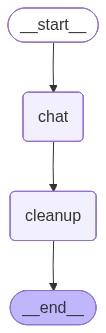

In [20]:
graph

In [11]:
config = {'configurable':{'thread_id':'thread-1'}}

In [21]:
graph.invoke({'messages':[{'role':'user',"content":"Hi, How are you"}]},config=config)
graph.invoke({'messages':[{'role':'user',"content":"My name is Tushar"}]},config=config)

{'messages': [HumanMessage(content='My name is Tushar', additional_kwargs={}, response_metadata={}, id='938d6c51-65c3-45a5-b445-f44f2b28fcb1'),
  AIMessage(content=" Hi Tushar! Nice to meet you. How can I help you today? I'm here to answer any questions you might have to the best of my ability. Let me know if there's something specific you'd like to know about. I'm happy to help!\n\nHere are a few topics I can assist with:\n\n* General knowledge\n* Mathematics\n* Science\n* Technology\n* English grammar and usage\n* Book summaries and recommendations\n* Language translation\n* And much more!\n\nJust let me know what you have in mind and I'll do my best to provide you with accurate and helpful information. If you have a complex question or a question that requires a lot of context, please provide as much detail as possible so I can give you the best possible answer.\n\nI'm also happy to help you with simple tasks, like setting alarms or finding recipes, if that's what you'd prefer. Just

In [22]:
snap = graph.get_state(config)
print("Stored Messages after cleanup: ",len(snap.values['messages']))

Stored Messages after cleanup:  2
